In [43]:
import csv
import re
import numpy as np

param_re = re.compile(r"ch(\d+)=(\-?\d+\.?\d*e?[+\-]?\d*)", re.IGNORECASE)
mc_re    = re.compile(r"mc_iteration=(\d+)", re.IGNORECASE)

def parse_puf_mc_csv(path, n_bits=8):
    """
    path: CSV exported from ADE with Parameters+diff rows
    returns:
      challenges : (n_challenges, n_bits) float
      bits       : (n_chips, n_challenges) int (1 if diff>0 else 0)
    """
    # data[(ch_tuple)][mc] = diff
    data = {}

    with open(path, newline='') as f:
        r = csv.reader(f)
        current_ch = None
        current_mc = None

        for row in r:
            if not row:
                continue

            # Parameters line
            if row[0].startswith("Parameters:"):
                line = row[0]

                # extract ch0..ch7
                vals = {int(m.group(1)): float(m.group(2))
                        for m in param_re.finditer(line)}
                current_ch = tuple(vals[i] for i in range(n_bits))

                # extract mc_iteration
                m = mc_re.search(line)
                current_mc = int(m.group(1)) if m else None

            # Data line with diff
            elif row[1:3] == ['base_setup', 'diff'] and row[3] and current_ch is not None:
                diff_str = row[3]
                # allow engineering suffixes like "27.12m"
                diff_str = diff_str.replace('m', 'e-3').replace('u', 'e-6')
                diff = float(diff_str)

                if current_ch not in data:
                    data[current_ch] = {}
                if current_mc is not None:
                    data[current_ch][current_mc] = diff

    # sort challenges to get deterministic order
    chal_list = sorted(data.keys())
    n_challenges = len(chal_list)

    # infer number of chips (max mc_iteration)
    example = next(iter(data.values()))
    n_chips = max(example.keys())

    challenges = np.array(chal_list, dtype=float)          # (n_challenges, 8)
    diffs = np.zeros((n_chips, n_challenges), dtype=float)

    for j, ch in enumerate(chal_list):
        for mc, d in data[ch].items():
            diffs[mc - 1, j] = d       # mc_iteration is 1‑based

    bits = (diffs > 0).astype(int)
    return challenges, bits


# -------- example usage --------
challenges, bits = parse_puf_mc_csv("data/8b30c.csv")
print("challenges shape:", challenges.shape)   # (256, 8)
print("bits shape:", bits.shape)              # (30, 256)


challenges shape: (256, 8)
bits shape: (30, 256)


In [44]:
import numpy as np

n_chips, n_challenges = bits.shape

def bit_aliasing(all_bits):
    return all_bits.mean(axis=0)

def challenge_wise_uniqueness(all_bits):
    """
    For each challenge j, compute mean HD over chip pairs (column-wise).
    Returns:
      ch_uniq: shape (n_challenges,)
    """
    n_chips, n_ch = all_bits.shape
    ch_uniq = np.zeros(n_ch)
    for j in range(n_ch):
        col = all_bits[:, j]           # (n_chips,)
        pair_hd = []
        for i in range(n_chips - 1):
            pair_hd.append(col[i] ^ col[i+1:])  # xor vs later chips
        ch_uniq[j] = np.mean(np.concatenate(pair_hd))
    return ch_uniq

# ---- compute everything ----

uniformities = []

for i in range(n_chips):

    uniformity = bits[i].mean()
    uniformities.append(uniformity)

uniformities = np.array(uniformities)  # shape (n_chips,)

alias = bit_aliasing(bits)

ch_uniq        = challenge_wise_uniqueness(bits)  

print("Uniformity mean, std:", uniformities.mean(), uniformities.std())
print("Challenge-wise uniqueness: mean, std:", ch_uniq.mean(), ch_uniq.std())
print("Bit aliasing mean:", alias.mean(), alias.std())


Uniformity mean, std: 0.5229166666666667 0.36778781453318593
Challenge-wise uniqueness: mean, std: 0.4951688218390805 0.03409666495060136
Bit aliasing mean: 0.5229166666666667 0.1007135997105985


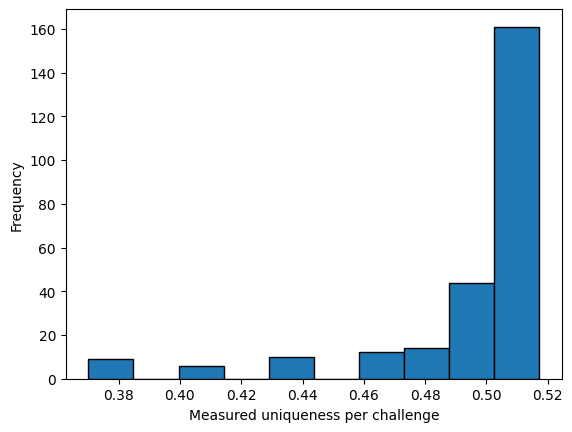

In [45]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(ch_uniq, bins=10, edgecolor='black')
plt.xlabel("Measured uniqueness per challenge")
plt.ylabel("Frequency")
plt.show()

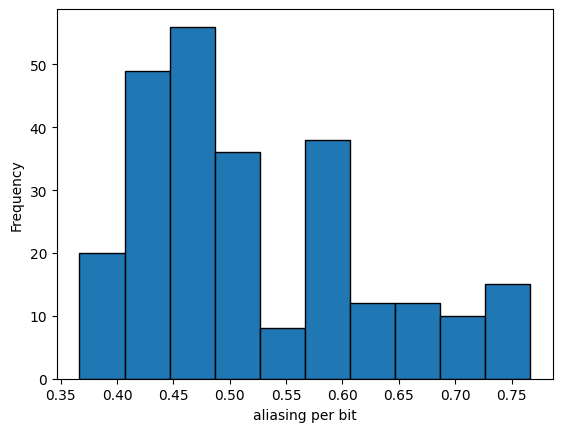

In [46]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(alias, bins=10, edgecolor='black')
plt.xlabel("aliasing per bit")
plt.ylabel("Frequency")
plt.show()

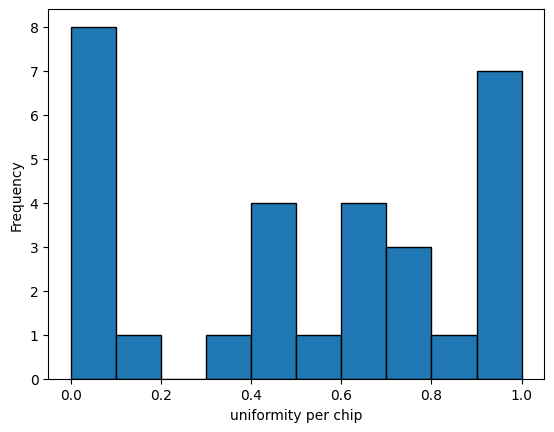

In [47]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(uniformities, bins=10, edgecolor='black')
plt.xlabel("uniformity per chip")
plt.ylabel("Frequency")
plt.show()